In [2]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
from sklearn.neighbors import NearestNeighbors
import random


# untuk tampilan lebih rapih
%matplotlib inline
sns.set(style='whitegrid')

In [4]:
# ubah path jika berbeda
path = '/content/CC GENERAL.csv'
df = pd.read_csv(path)


# info awal
print('Shape:', df.shape)
df.info()
df.head()


# statistik ringkas
df.describe().T

Shape: (8950, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   i

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


In [5]:
# cek missing values
df.isnull().sum().sort_values(ascending=False)

,0
MINIMUM_PAYMENTS,313
CREDIT_LIMIT,1
BALANCE,0
CUST_ID,0
BALANCE_FREQUENCY,0
PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0


In [8]:
# Contoh: lihat kolom numerik
num_df = df.select_dtypes(include=['int64','float64']).copy()
num_df.columns


# Imputasi: gunakan mean untuk kolom numeric yang memiliki missing values
for col in num_df.columns:
  if num_df[col].isnull().sum() > 0:
    # beberapa kolom seperti 'CREDIT_LIMIT' atau 'MINIMUM_PAYMENTS' umum kosong
    num_df[col].fillna(num_df[col].mean(), inplace=True)


# Buat fitur baru: BALANCE to PURCHASES ratio
# Pastikan kolom memang ada, jika tidak, ganti sesuai nama di dataset
if 'BALANCE' in num_df.columns and 'PURCHASES' in num_df.columns:
  eps = 1e-6
  num_df['BALANCE_to_PURCHASES'] = num_df['BALANCE'] / (num_df['PURCHASES'] + eps)
else:
  print('Kolom BALANCE atau PURCHASES tidak ditemukan, cek nama kolom dataset Anda')


# Pilih fitur yang akan digunakan untuk clustering (anda bisa menyesuaikan)
# Umumnya kita masukkan sebagian besar fitur numerik kecuali ID
features = [c for c in num_df.columns if c.upper() not in ['CUST_ID','CUSTID','ID']]
X = num_df[features].copy()


# Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


print('Shape X_scaled:', X_scaled.shape)

Shape X_scaled: (8950, 18)


/tmp/ipython-input-3122419584.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  num_df[col].fillna(num_df[col].mean(), inplace=True)


In [9]:
# coba beberapa k
sil_scores = {}
db_scores = {}
from tqdm import tqdm


for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  labels = kmeans.fit_predict(X_scaled)
  sil = silhouette_score(X_scaled, labels)
  db = davies_bouldin_score(X_scaled, labels)
  sil_scores[k] = sil
  db_scores[k] = db


# tampilkan hasil
print('Silhouette scores:')
for k, s in sil_scores.items():
  print(k, round(s,4))
print('\nDavies-Bouldin scores:')
for k, d in db_scores.items():
  print(k, round(d,4))


# pilih k terbaik berdasarkan silhouette (max)
best_k = max(sil_scores, key=sil_scores.get)
print('\nBest K by Silhouette:', best_k)


# fit final KMeans
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_scaled)


# simpan centroids (untuk referensi)
centroids = kmeans_final.cluster_centers_

Silhouette scores:
2 0.1967
3 0.2469
4 0.1855
5 0.1802
6 0.1907
7 0.2016
8 0.2121
9 0.2188
10 0.2224

Davies-Bouldin scores:
2 1.9404
3 1.6271
4 1.6169
5 1.5824
6 1.544
7 1.443
8 1.4754
9 1.4387
10 1.3551

Best K by Silhouette: 3


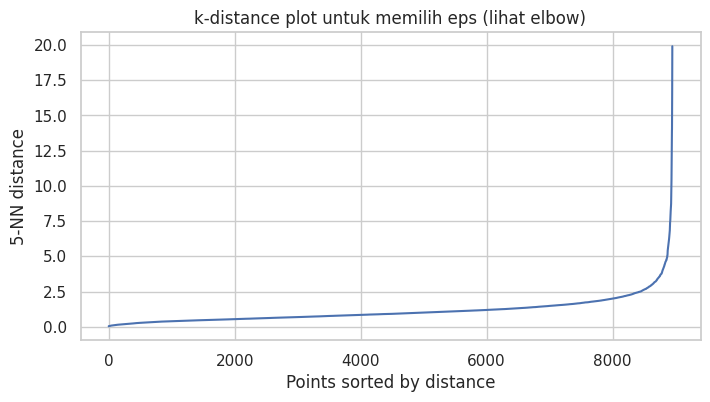

In [10]:
# gunakan NearestNeighbors untuk k-dist plot (k = min_samples)
min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
dists, idxs = nbrs.kneighbors(X_scaled)
# ambil jarak ke tetangga k-th terbesar -> untuk semua point ambil dists[:, -1]
d_k = np.sort(dists[:, -1])


# plot k-distance
plt.figure(figsize=(8,4))
plt.plot(d_k)
plt.ylabel(f'{min_samples}-NN distance')
plt.xlabel('Points sorted by distance')
plt.title('k-distance plot untuk memilih eps (lihat elbow)')
plt.show()

In [11]:
# Contoh nilai eps; ganti setelah melihat plot
eps_choice = 0.8
dbscan = DBSCAN(eps=eps_choice, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(X_scaled)


# hitung berapa banyak cluster (abaikan noise label -1)
unique_labels = set(labels_dbscan)
n_clusters_dbscan = len([l for l in unique_labels if l != -1])
print('Jumlah cluster (DBSCAN, tidak termasuk noise):', n_clusters_dbscan)
print('Jumlah noise points (label -1):', list(labels_dbscan).count(-1))


# Evaluasi: silhouette dan DBI hanya jika ada >=2 cluster (non-noise)
mask_non_noise = labels_dbscan != -1
if len(set(labels_dbscan[mask_non_noise])) > 1:
  sil_dbscan = silhouette_score(X_scaled[mask_non_noise], labels_dbscan[mask_non_noise])
  db_dbscan = davies_bouldin_score(X_scaled[mask_non_noise], labels_dbscan[mask_non_noise])
  print('DBSCAN Silhouette (non-noise):', sil_dbscan)
  print('DBSCAN Davies-Bouldin (non-noise):', db_dbscan)
else:
  print('Tidak cukup cluster (non-noise) untuk menghitung metrik DBSCAN')

Jumlah cluster (DBSCAN, tidak termasuk noise): 22
Jumlah noise points (label -1): 4555
DBSCAN Silhouette (non-noise): -0.2579686322838496
DBSCAN Davies-Bouldin (non-noise): 0.9877977688589644


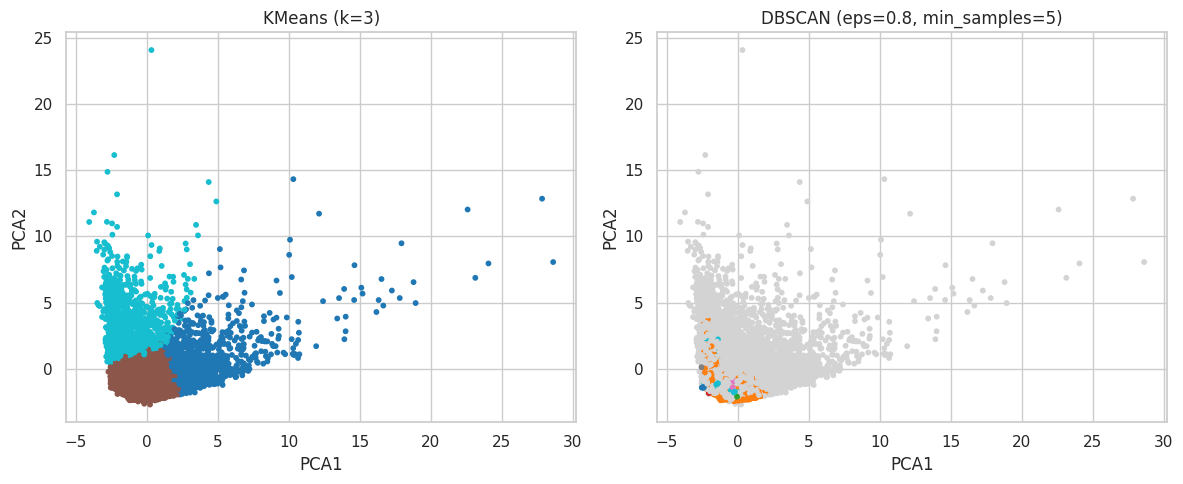

In [14]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='tab10', s=10)
plt.title(f'KMeans (k={best_k})')
plt.xlabel('PCA1')
plt.ylabel('PCA2')


plt.subplot(1,2,2)
# for DBSCAN, assign a distinct color for noise (-1)
unique_labels_dbscan = set(labels_dbscan)
colors = [plt.cm.tab10(each) for each in unique_labels_dbscan]
# Map labels to colors, handle noise with a specific color
color_map_dbscan = {-1: 'lightgrey'}
for i, label in enumerate(sorted(list(unique_labels_dbscan))):
    if label != -1:
        color_map_dbscan[label] = colors[i]

point_colors_dbscan = [color_map_dbscan[label] for label in labels_dbscan]

plt.scatter(X_pca[:,0], X_pca[:,1], c=point_colors_dbscan, s=10)
plt.title(f'DBSCAN (eps={eps_choice}, min_samples={min_samples})')
plt.xlabel('PCA1')
plt.ylabel('PCA2')


plt.tight_layout()
plt.show()

In [16]:
# Add KMeans cluster labels to the original dataframe
df['KMeans_Cluster'] = labels_kmeans

# Analyze cluster characteristics
# Drop 'CUST_ID' before calculating the mean
cluster_characteristics_kmeans = df.drop('CUST_ID', axis=1).groupby('KMeans_Cluster').mean()

# Display the characteristics
print("KMeans Cluster Characteristics:")
display(cluster_characteristics_kmeans)

KMeans Cluster Characteristics:


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
KMeans_Cluster,,,,,,,,,,,,,,,,,
0,2324.891099,0.981393,4254.921588,2716.413631,1538.986808,542.947459,0.946892,0.664329,0.744366,0.072230,1.829210,56.391860,7785.474860,4192.864786,1329.506213,0.289505,11.917797
1,765.515243,0.832139,529.368407,265.840187,263.858882,319.740247,0.483657,0.138756,0.358321,0.066327,1.188239,9.026987,3279.074795,931.516252,535.406693,0.160588,11.484924
2,3833.278132,0.960189,277.135750,178.754162,98.441606,3637.061740,0.176381,0.086565,0.105091,0.425547,11.600945,4.017119,6366.364352,2754.478063,1644.191009,0.028918,11.335891


In [17]:
# Build Annoy index
dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, metric='euclidean')
for i, v in enumerate(X_scaled):
  ann.add_item(i, v)
ann.build(n_trees=50)


# Pilih query indices (3-5 random)
random.seed(42)
n_queries = 5
query_indices = random.sample(range(X_scaled.shape[0]), n_queries)


# ambil tetangga terdekat (mis. top 10)
n_neighbors = 10
results = {}
for q in query_indices:
  neighbors, distances = ann.get_nns_by_item(q, n_neighbors, include_distances=True)
results[q] = (neighbors, distances)


# Tampilkan
for q, (nbrs, dists) in results.items():
  print('\nQuery Point Index:', q)
  print('Cluster (KMeans):', labels_kmeans[q])
  print('Neighbors (idx) | Distance | Cluster(KMeans)')
  for ni, di in zip(nbrs, dists):
    print(f'{ni:6d} | {di:.4f} | {labels_kmeans[ni]}')


Query Point Index: 3657
Cluster (KMeans): 1
Neighbors (idx) | Distance | Cluster(KMeans)
  3657 | 0.0000 | 1
  2103 | 0.5175 | 1
  4825 | 0.6116 | 1
   746 | 0.6138 | 1
  5006 | 0.6937 | 1
  7074 | 0.7269 | 1
  2826 | 0.7396 | 1
  5536 | 0.7491 | 1
  5316 | 0.7800 | 1
  1014 | 0.7812 | 1


In [18]:
# Simpan label ke dataframe
df_out = df.copy()
df_out['kmeans_label'] = labels_kmeans
# jika DBSCAN sudah ada
try:
  df_out['dbscan_label'] = labels_dbscan
except:
  pass


# simpan ke csv
df_out.to_csv('/content/CC_GENERAL_with_labels.csv', index=False)
print('Saved to /content/CC_GENERAL_with_labels.csv')

Saved to /content/CC_GENERAL_with_labels.csv
